In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from lassolver.utils.func import *
from lassolver.utils.signal import *
from lassolver.utils.utils import *

from lassolver.matrices.iid_gauss import iidGaussian
from lassolver.matrices.uni_invar import UniInvar

from lassolver.solver.amp import AMP
from lassolver.solver.oamp import OAMP

from lassolver.dsolver.d_amp import D_AMP
from lassolver.dsolver.d_oamp import D_OAMP

# 条件数の増加に対する疎信号再構成の性能比較

In [ ]:
N = 500  # 列数
alpha = 0.5  # 圧縮率
M = int(alpha*N)  # 行数
rho = 0.2  # 非零成分の割合

In [ ]:
SNR = 60  # 信号対雑音比
P = 10  # ノード数
T = 50  # 反復回数
sim = int(1e+6)  # 範囲
realization = 100  # 実験数
judge = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]  # 実験を行う回

In [ ]:
MSE_oamp = np.zeros((2, realization, sim))
MSE_doamp = np.zeros((2, realization, sim))
MSE_doamp_approx = np.zeros((2, realization, sim))

In [ ]:
lenj = len(judge)
CommCost_doamp = np.empty((2, lenj, realization, T))
CommCost_doamp_approx = np.empty((2, lenj, realization, T))

In [ ]:
for i in tqdm(range(realization)):
  x = bernouli_gaussian(N, rho)
  UniInv = UniInvar(M, N, 1)
  count = 0

  for j in range(sim):
    kappa = j+1
    if kappa not in judge: continue

    UniInv.change_cond(kappa)
    oamp = [0, 0]
    doamp = [0, 0]
    doamp_approx = [0, 0]

    for k in range(2):
      oamp[k] = OAMP(UniInv.A, x, SNR)
      doamp[k] = D_OAMP(UniInv.A, x, SNR, P)
      doamp_approx[k] = D_OAMP(UniInv.A, x, SNR, P)

    oamp[0].estimate(T=T, ord='PINV')
    oamp[1].estimate(T=T, ord='LMMSE')
    doamp[0].estimate(T=T, C=1.9, ord='PINV')
    doamp[1].estimate(T=T, C=1.9, ord='LMMSE')
    doamp_approx[0].estimate(T=T, C=1.9, ord='PINV', approx=True)
    doamp_approx[1].estimate(T=T, C=1.9, ord='LMMSE', approx=True)

    for k in range(2):
      MSE_oamp[k, i, j] = oamp[k].mse[-1]
      MSE_doamp[k, i, j] = doamp[k].mse[-1]
      MSE_doamp_approx[k, i, j] = doamp_approx[k].mse[-1]

      CommCost_doamp[k, count, i] = doamp[k].communication_cost
      CommCost_doamp_approx[k, count, i] = doamp_approx[k].communication_cost

    count += 1

100%|██████████| 100/100 [8:15:32<00:00, 297.32s/it]


In [ ]:
mean_MSE_oamp = np.empty((2, sim))
mean_MSE_doamp = np.empty((2, sim))
mean_MSE_doamp_approx = np.empty((2, sim))

In [ ]:
for i in range(2):
  mean_MSE_oamp[i] = np.mean(MSE_oamp[i], axis=0)
  mean_MSE_doamp[i] = np.mean(MSE_doamp[i], axis=0)
  mean_MSE_doamp_approx[i] = np.mean(MSE_doamp_approx[i], axis=0)

In [ ]:
for i in range(2):
  for j in range(sim):
    if mean_MSE_oamp[i, j] == 0:
      mean_MSE_oamp[i, j] = None
    if mean_MSE_doamp[i, j] == 0:
      mean_MSE_doamp[i, j] = None
    if mean_MSE_doamp_approx[i, j] == 0:
      mean_MSE_doamp_approx[i, j] = None

In [ ]:
mean_CommCost_doamp = np.empty((2, lenj, T))
mean_CommCost_doamp_approx = np.empty((2, lenj, T))

In [ ]:
for i in range(2):
  for j in range(lenj):
    mean_CommCost_doamp[i, j] = np.mean(CommCost_doamp[i, j], axis=0)
    mean_CommCost_doamp_approx[i, j] = np.mean(CommCost_doamp_approx[i, j], axis=0)

# MSE

In [ ]:
it = np.arange(0, sim, 1)

In [ ]:
def pltMSE(ord):
  plt.xlabel('condition number κ')
  plt.ylabel('MSE')
  plt.xscale('log')
  plt.yscale('log')

  if ord == "OAMP": meanMSE = mean_MSE_oamp
  elif ord == "D-OAMP": meanMSE = mean_MSE_doamp
  elif ord == "D-OAMP Approx": meanMSE = mean_MSE_doamp_approx
  else : raise NameError("Enter one of OAMP, D-OAMP, or D-OAMP Approx for the argument (ord)")

  sp = meanMSE[0].astype(np.double)
  mp = np.isfinite(sp)

  sl = meanMSE[1].astype(np.double)
  ml = np.isfinite(sl)

  plt.plot(it[mp], sp[mp], label=lname(ord, "PINV"))
  plt.plot(it[ml], sl[ml], label=lname(ord, "LMMSE"))

  plt.legend()
  plt.grid()

def lname(ord, case):
  if ord == "D-OAMP Approx": name = ord.replace(" ", "-" + case + " ")
  else : name = ord + "-" + case
  return name

In [ ]:
def pltMSE_all():
  plt.xlabel('condition number κ')
  plt.ylabel('MSE')
  plt.xscale('log')
  plt.yscale('log')

  scp = mean_MSE_oamp[0].astype(np.double)
  mcp = np.isfinite(scp)
  scl = mean_MSE_oamp[1].astype(np.double)
  mcl = np.isfinite(scl)

  sdp = mean_MSE_doamp[0].astype(np.double)
  mdp = np.isfinite(sdp)
  sdl = mean_MSE_doamp[1].astype(np.double)
  mdl = np.isfinite(sdl)

  sdpX = mean_MSE_doamp_approx[0].astype(np.double)
  mdpX = np.isfinite(sdpX)
  sdlX = mean_MSE_doamp_approx[1].astype(np.double)
  mdlX = np.isfinite(sdlX)

  plt.plot(it[mcp], scp[mcp], label=lname('OAMP', 'PINV'))
  plt.plot(it[mcl], scl[mcl], label=lname('OAMP', 'LMMSE'))
  plt.plot(it[mdp], sdp[mdp], linestyle='--', color='b', label=lname('D-OAMP', 'PINV'))
  plt.plot(it[mdl], sdl[mdl], linestyle='--', color='r', label=lname('D-OAMP', 'LMMSE'))
  plt.plot(it[mdpX], sdpX[mdpX], linestyle=':', color='aqua', label=lname('D-OAMP Approx', 'PINV'))
  plt.plot(it[mdlX], sdlX[mdlX], linestyle=':', color='orangered', label=lname('D-OAMP Approx', 'LMMSE'))

  plt.legend()
  plt.grid()

In [ ]:
def pltMSE_cd():
  plt.xlabel('condition number κ')
  plt.ylabel('MSE')
  plt.xscale('log')
  plt.yscale('log')

  scp = mean_MSE_oamp[0].astype(np.double)
  mcp = np.isfinite(scp)
  scl = mean_MSE_oamp[1].astype(np.double)
  mcl = np.isfinite(scl)

  sdp = mean_MSE_doamp[0].astype(np.double)
  mdp = np.isfinite(sdp)
  sdl = mean_MSE_doamp[1].astype(np.double)
  mdl = np.isfinite(sdl)

  plt.plot(it[mcp], scp[mcp], label=lname('OAMP', 'PINV'))
  plt.plot(it[mcl], scl[mcl], label=lname('OAMP', 'LMMSE'))
  plt.plot(it[mdp], sdp[mdp], linestyle='--', color='b', label=lname('D-OAMP', 'PINV'))
  plt.plot(it[mdl], sdl[mdl], linestyle='--', color='r', label=lname('D-OAMP', 'LMMSE'))

  plt.legend()
  plt.grid()

In [ ]:
def pltMSE_AX():
  plt.xlabel('condition number κ')
  plt.ylabel('MSE')
  plt.xscale('log')
  plt.yscale('log')

  sdp = mean_MSE_doamp[0].astype(np.double)
  mdp = np.isfinite(sdp)
  sdl = mean_MSE_doamp[1].astype(np.double)
  mdl = np.isfinite(sdl)

  sdpX = mean_MSE_doamp_approx[0].astype(np.double)
  mdpX = np.isfinite(sdpX)
  sdlX = mean_MSE_doamp_approx[1].astype(np.double)
  mdlX = np.isfinite(sdlX)

  plt.plot(it[mdp], sdp[mdp], linestyle='--', color='b', label=lname('D-OAMP', 'PINV'))
  plt.plot(it[mdl], sdl[mdl], linestyle='--', color='r', label=lname('D-OAMP', 'LMMSE'))
  plt.plot(it[mdpX], sdpX[mdpX], linestyle=':', color='aqua', label=lname('D-OAMP Approx', 'PINV'))
  plt.plot(it[mdlX], sdlX[mdlX], linestyle=':', color='orangered', label=lname('D-OAMP Approx', 'LMMSE'))

  plt.legend()
  plt.grid()

## OAMPの場合

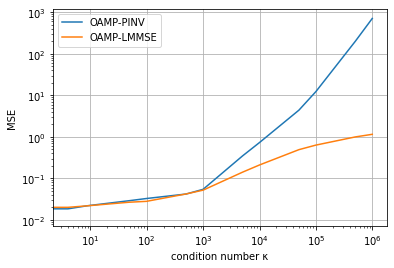

In [ ]:
pltMSE("OAMP")

## D-OAMP(近似なし)の場合

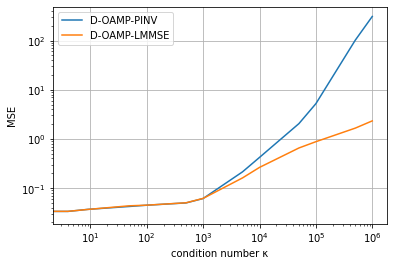

In [ ]:
pltMSE("D-OAMP")

## D-OAMP(近似あり)の場合

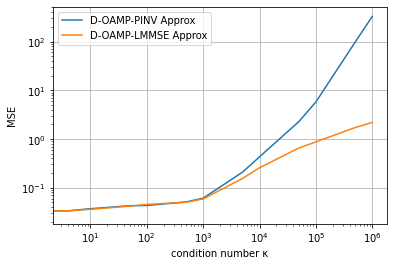

In [ ]:
pltMSE("D-OAMP Approx")

## すべて

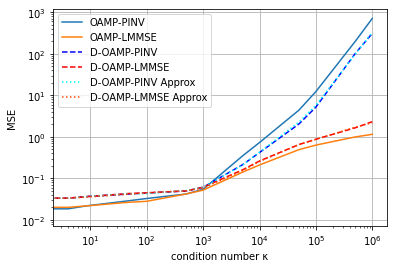

In [ ]:
pltMSE_all()

## OAMPとD-OAMP(近似なし)

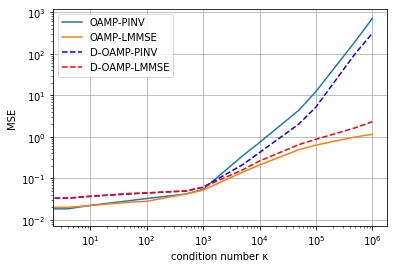

In [ ]:
pltMSE_cd()

## D-OAMP(近似なし)とD-OAMP(近似あり)

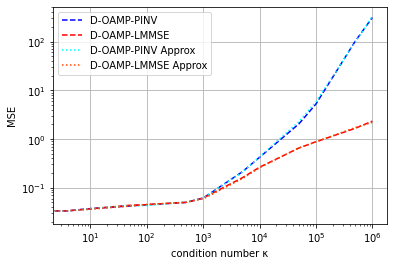

In [ ]:
pltMSE_AX()

# 通信量

In [ ]:
ix2 = np.arange(0, T, 5)
it2 = np.arange(0, T, 1)

standard = np.array([N * (P - 1) for _ in range(T)])

## D-OAMP(近似なし)の場合

In [ ]:
def pltCC(kappa):
  plt.figure(figsize=(6, 5.5))

  plt.title('κ = ' + str(kappa))
  plt.xlabel('iteration')
  plt.ylabel('Communication Cost')
  
  num = 0
  for _ in range(lenj):
    if kappa % 2 == 0:
      kappa /= 2
      num += 1 
    if kappa % 5 == 0: 
      kappa /= 5
      num += 1

  plt.xticks(ix2)

  plt.plot(it2, mean_CommCost_doamp[0, num], label='D-OAMP-PINV')
  plt.plot(it2, mean_CommCost_doamp[1, num], label='D-OAMP-LMMSE')
  plt.plot(it2, standard, ls='--', color='r', label='Standard')

  plt.legend()

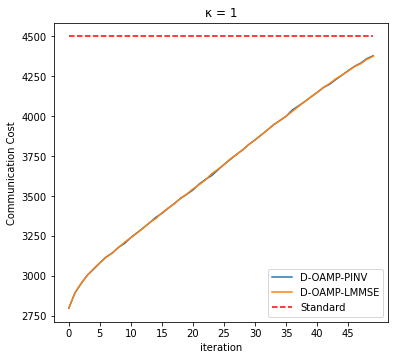

In [ ]:
pltCC(judge[0])

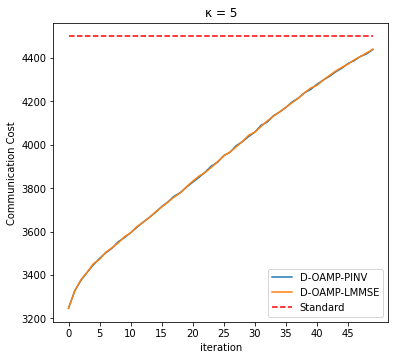

In [ ]:
pltCC(judge[1])

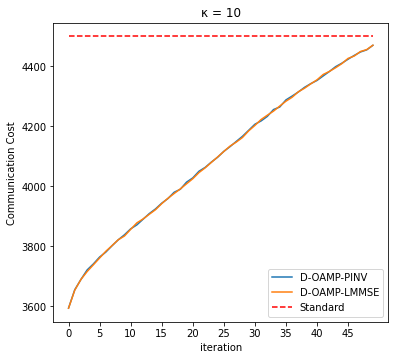

In [ ]:
pltCC(judge[2])

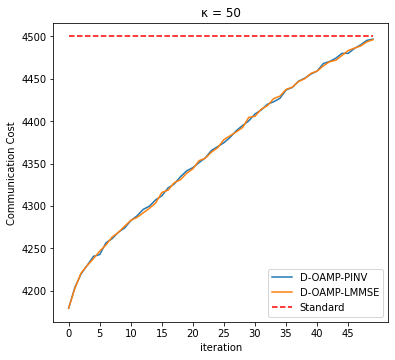

In [ ]:
pltCC(judge[3])

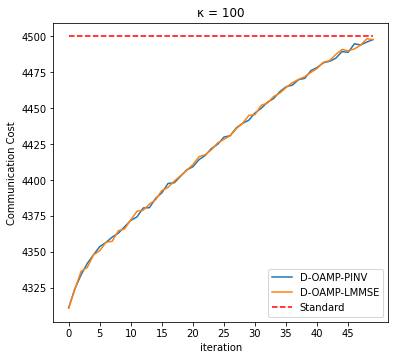

In [ ]:
pltCC(judge[4])

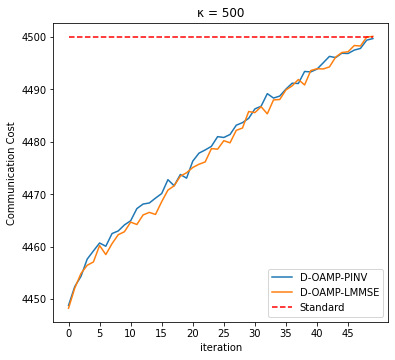

In [ ]:
pltCC(judge[5])

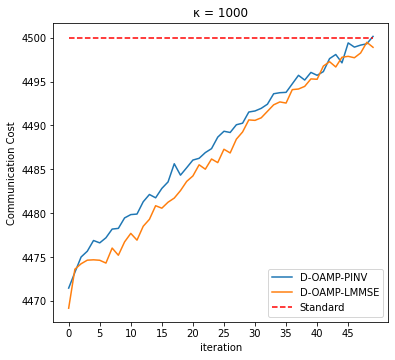

In [ ]:
pltCC(judge[6])

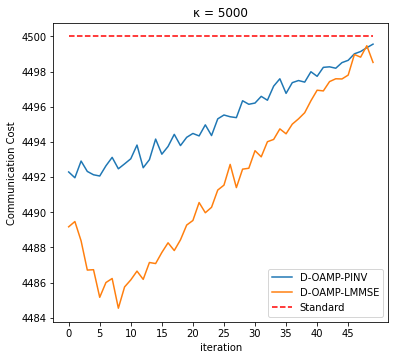

In [ ]:
pltCC(judge[7])

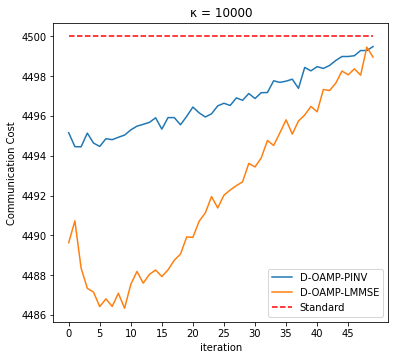

In [ ]:
pltCC(judge[8])

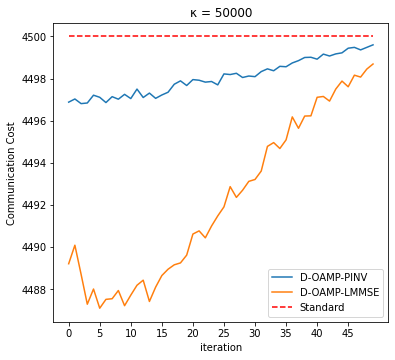

In [ ]:
pltCC(judge[9])

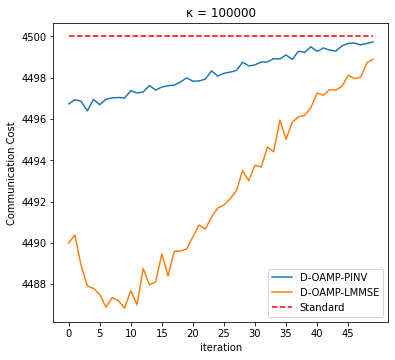

In [ ]:
pltCC(judge[10])

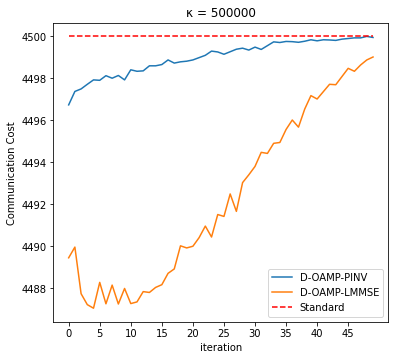

In [ ]:
pltCC(judge[11])

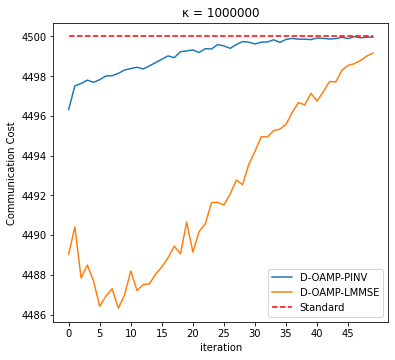

In [ ]:
pltCC(judge[12])

## D-OAMP(近似あり)の場合

In [ ]:
def pltCC_approx(kappa):
  plt.figure(figsize=(6, 5.5))

  plt.title('κ = ' + str(kappa))
  plt.xlabel('iteration')
  plt.ylabel('Communication Cost')
  
  num = 0
  for _ in range(lenj):
    if kappa % 2 == 0:
      kappa /= 2
      num += 1 
    if kappa % 5 == 0: 
      kappa /= 5
      num += 1

  plt.xticks(ix2)

  plt.plot(it2, mean_CommCost_doamp_approx[0, num], label='D-OAMP-PINV Approx')
  plt.plot(it2, mean_CommCost_doamp_approx[1, num], label='D-OAMP-LMMSE Approx')
  plt.plot(it2, standard, ls='--', color='r', label='Standard')

  plt.legend()

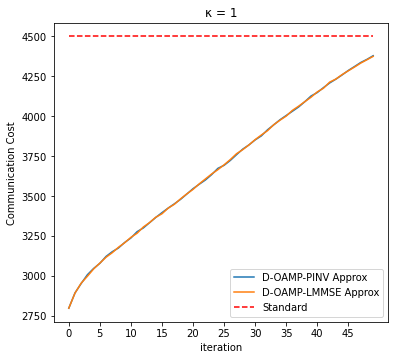

In [ ]:
pltCC_approx(judge[0])

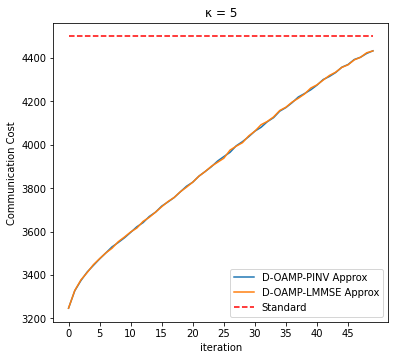

In [ ]:
pltCC_approx(judge[1])

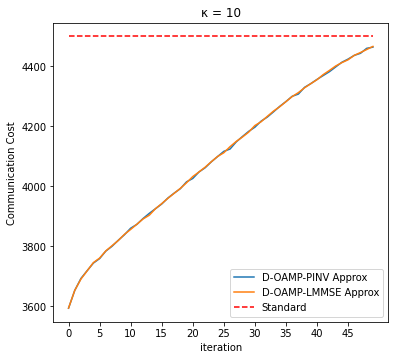

In [ ]:
pltCC_approx(judge[2])

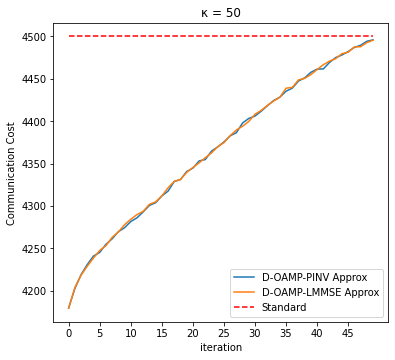

In [ ]:
pltCC_approx(judge[3])

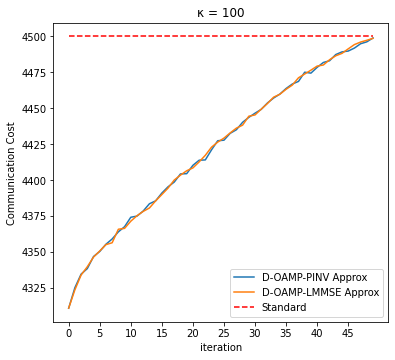

In [ ]:
pltCC_approx(judge[4])

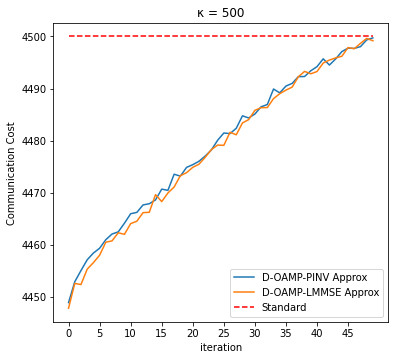

In [ ]:
pltCC_approx(judge[5])

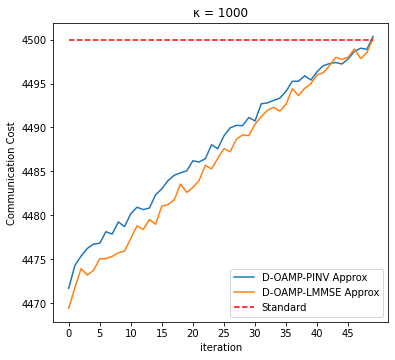

In [ ]:
pltCC_approx(judge[6])

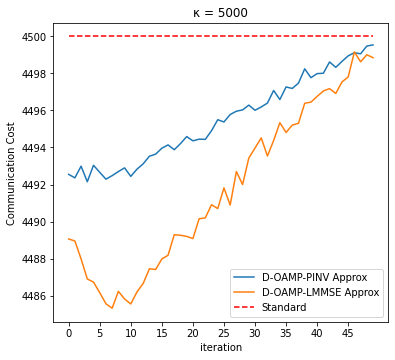

In [ ]:
pltCC_approx(judge[7])

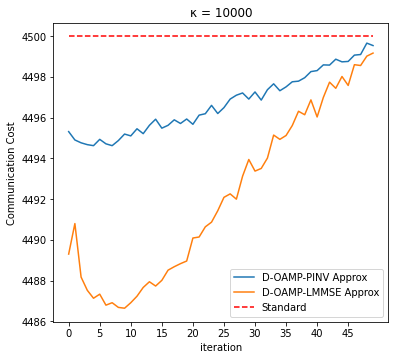

In [ ]:
pltCC_approx(judge[8])

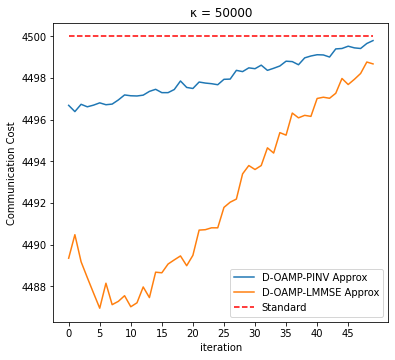

In [ ]:
pltCC_approx(judge[9])

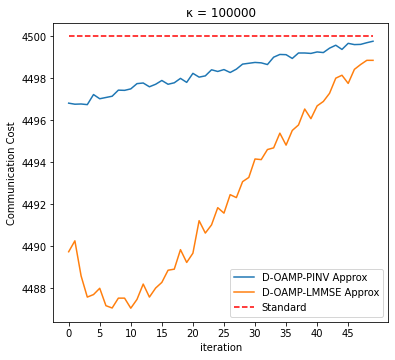

In [ ]:
pltCC_approx(judge[10])

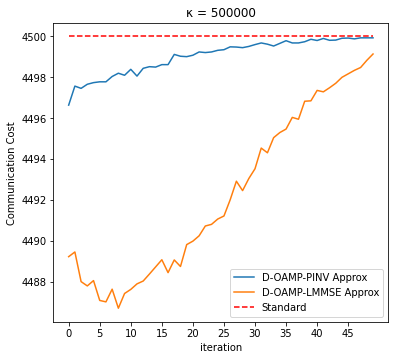

In [ ]:
pltCC_approx(judge[11])

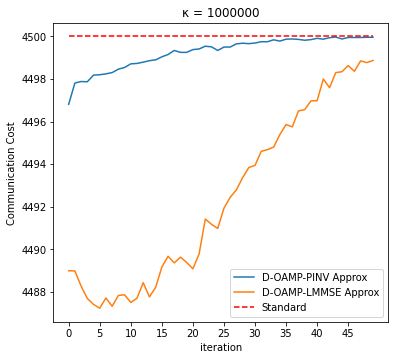

In [ ]:
pltCC_approx(judge[12])